## AI-Powered Early Warning System for Hospital Resource Shortages

Hospitals often experience sudden demand surges caused by seasonal diseases,
emergencies, or epidemics. These surges lead to resource shortages such as beds,
ICU capacity, and ventilators.

This notebook implements a predictive decision-support system that:

• Forecasts future hospital resource utilization  
• Computes a composite Hospital Stress Index (HSI)  
• Generates interpretable early warnings  
• Supports proactive hospital resource planning  

The system uses privacy-safe aggregated operational data.

In [16]:
pip install prophet

   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.1 MB 4.7 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/12.1 MB 3.1 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/12.1 MB 2.9 MB/s eta 0:00:04
   ------- -------------------------------- 2.4/12.1 MB 2.9 MB/s eta 0:00:04
   --------- ------------------------------ 2.9/12.1 MB 2.8 MB/s eta 0:00:04
   ----------- ---------------------------- 3.4/12.1 MB 2.7 MB/s eta 0:00:04
   ------------ --------------------------- 3.9/12.1 MB 2.7 MB/s eta 0:00:04
   -------------- ------------------------- 4.5/12.1 MB 2.6 MB/s eta 0:00:03
   ---------------- ----------------------- 5.0/12.1 MB 2.6 MB/s eta 0:00:03
   ------------------ --------------------- 5.5/12.1 MB 2.6 MB/s eta 0:00:03
   ------------------- -------------------- 6.0/12.1 MB 2.6 MB/s eta 0:00:03
   --------------------- ------------------ 6.6/12.1 MB 2.6 MB/s eta 0:00:03
   ---

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [5]:
data = pd.read_csv("hospital_resource_shortage_dataset_1000_rows_cleaned.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

print("Dataset shape:", data.shape)
data.head()

Dataset shape: (1000, 22)


,City,Date,Day_of_Week,Month,Season,Public_Holiday,Total_Beds,Available_Beds,ICU_Total,ICU_Available,...,Staff_On_Duty,Daily_Admissions,Emergency_Admissions,Scheduled_Admissions,Daily_Discharges,Bed_Occupancy_Rate,ICU_Occupancy_Rate,Ventilator_Utilization_Rate,Resource_Shortage_Flag,Shortage_Type
0,Metro City,2022-01-01,Saturday,1,Winter,1,300,0,50,10,...,135,110,47,63,78,100.0,80.0,42.5,1,Beds
1,Metro City,2022-01-02,Sunday,1,Winter,1,300,0,50,5,...,121,109,65,44,93,100.0,90.0,57.5,1,Beds
2,Metro City,2022-01-03,Monday,1,Winter,0,300,0,50,9,...,112,111,54,57,99,100.0,82.0,70.0,1,Beds
3,Metro City,2022-01-04,Tuesday,1,Winter,0,300,30,50,23,...,139,112,65,47,94,90.0,54.0,30.0,0,NaN
4,Metro City,2022-01-05,Wednesday,1,Winter,0,300,36,50,16,...,123,111,53,58,82,88.0,68.0,45.0,0,NaN


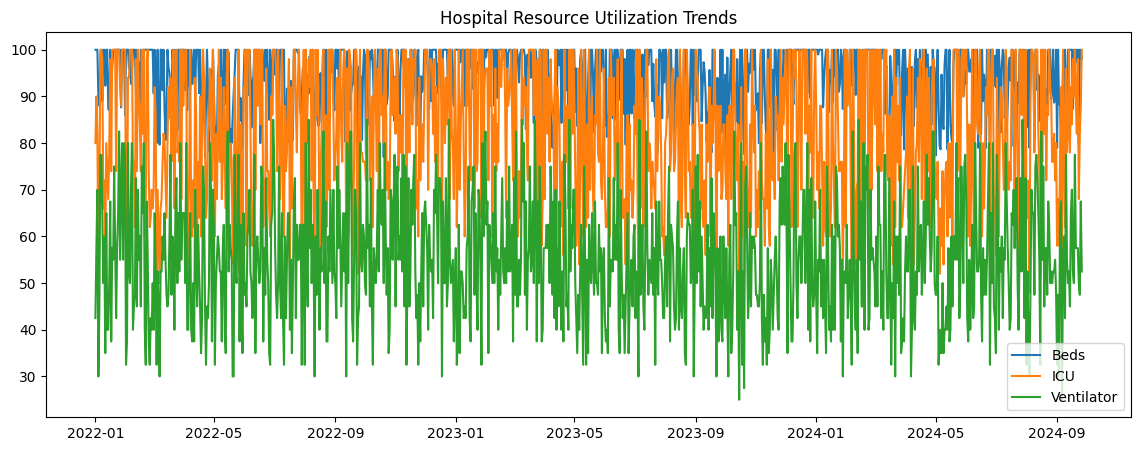

In [6]:
plt.figure(figsize=(14,5))
plt.plot(data['Date'], data['Bed_Occupancy_Rate'], label="Beds")
plt.plot(data['Date'], data['ICU_Occupancy_Rate'], label="ICU")
plt.plot(data['Date'], data['Ventilator_Utilization_Rate'], label="Ventilator")
plt.legend()
plt.title("Hospital Resource Utilization Trends")
plt.show()

In [7]:
data['Emergency_Pressure'] = (
    data['Emergency_Admissions'] / data['Emergency_Admissions'].max() * 100
)

In [8]:
data['Bed_Momentum'] = data['Bed_Occupancy_Rate'].diff().fillna(0)
data['ICU_Momentum'] = data['ICU_Occupancy_Rate'].diff().fillna(0)

In [9]:
data['HSI'] = (
    0.35 * data['Bed_Occupancy_Rate'] +
    0.25 * data['ICU_Occupancy_Rate'] +
    0.20 * data['Ventilator_Utilization_Rate'] +
    0.15 * data['Emergency_Pressure'] +
    0.05 * data['Bed_Momentum']
)

In [10]:
def classify_hsi(x):
    if x > 85:
        return "CRITICAL"
    elif x > 70:
        return "HIGH"
    elif x > 50:
        return "MODERATE"
    else:
        return "LOW"

data['Stress_Level'] = data['HSI'].apply(classify_hsi)
data[['Date','HSI','Stress_Level']].tail()

,Date,HSI,Stress_Level
995,2024-09-22,79.096463,HIGH
996,2024-09-23,60.164296,MODERATE
997,2024-09-24,72.683167,HIGH
998,2024-09-25,79.203704,HIGH
999,2024-09-26,78.218519,HIGH


In [11]:
def prophet_forecast(df, column, periods=30):
    temp = df[['Date', column]].rename(columns={'Date':'ds', column:'y'})
    
    model = Prophet()   # ✅ capital P
    model.fit(temp)

    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    return model, forecast

In [12]:
bed_model, bed_forecast = prophet_forecast(data, 'Bed_Occupancy_Rate')
icu_model, icu_forecast = prophet_forecast(data, 'ICU_Occupancy_Rate')
hsi_model, hsi_forecast = prophet_forecast(data, 'HSI')

15:09:03 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing
15:09:07 - cmdstanpy - INFO - Chain [1] start processing
15:09:07 - cmdstanpy - INFO - Chain [1] done processing
15:09:08 - cmdstanpy - INFO - Chain [1] start processing
15:09:08 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
hsi_forecast['Alert'] = hsi_forecast['yhat'].apply(
    lambda x: " CRITICAL SHORTAGE RISK" if x > 80 else "NORMAL"
)

hsi_forecast[['ds','yhat','Alert']].tail(20)

,ds,yhat,Alert
1010,2024-10-07,71.574017,NORMAL
1011,2024-10-08,71.180706,NORMAL
1012,2024-10-09,72.185561,NORMAL
1013,2024-10-10,72.156407,NORMAL
1014,2024-10-11,72.359820,NORMAL
1015,2024-10-12,72.293685,NORMAL
1016,2024-10-13,72.213122,NORMAL
1017,2024-10-14,72.392638,NORMAL
1018,2024-10-15,72.139111,NORMAL
1019,2024-10-16,73.266758,NORMAL


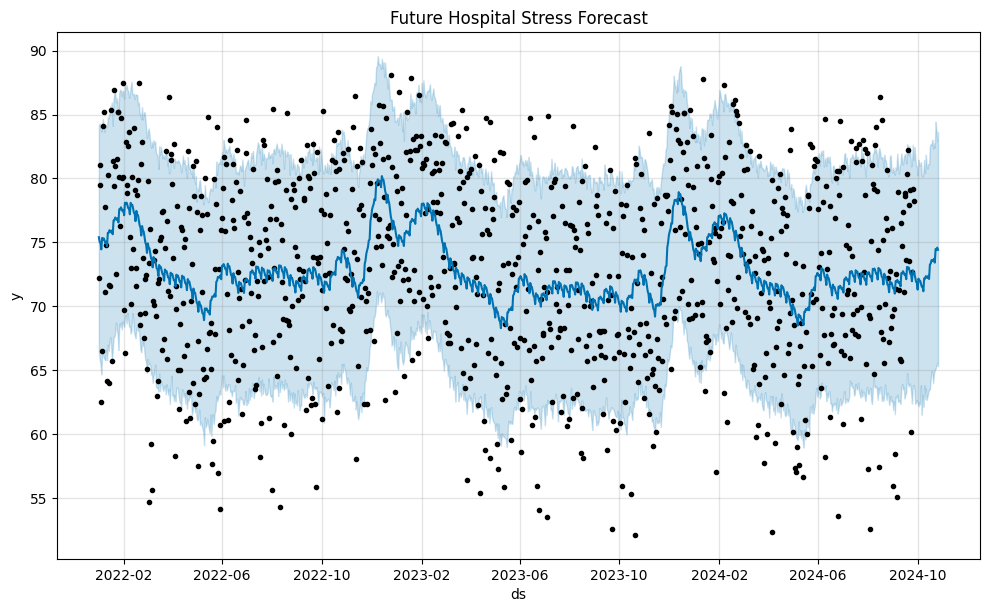

In [14]:
hsi_model.plot(hsi_forecast)
plt.title("Future Hospital Stress Forecast")
plt.show()

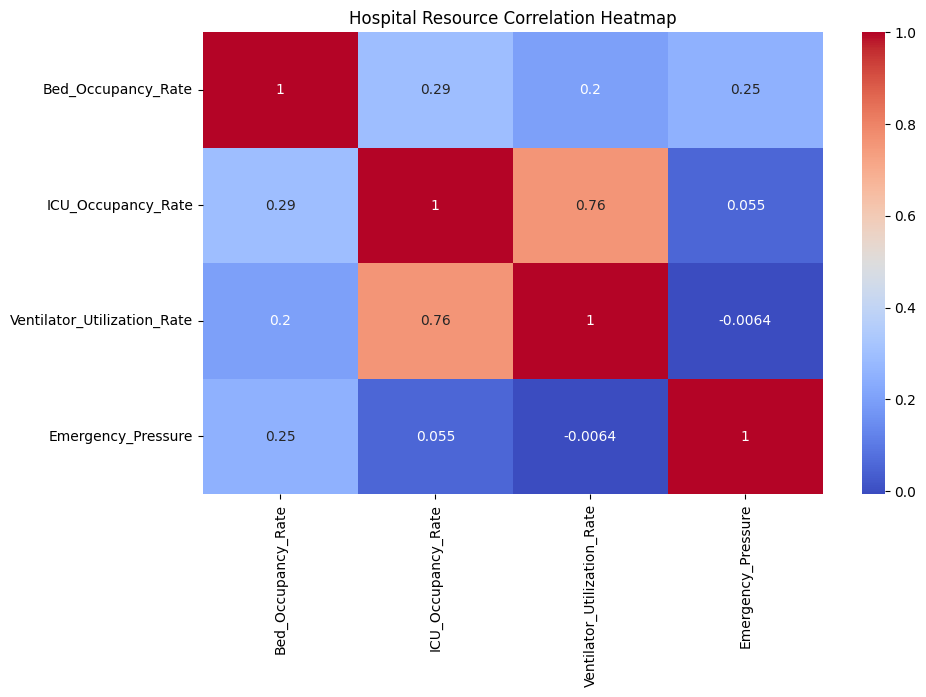

In [15]:
import seaborn as sns

heatmap_data = data[['Bed_Occupancy_Rate','ICU_Occupancy_Rate',
                     'Ventilator_Utilization_Rate','Emergency_Pressure']]

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm')
plt.title("Hospital Resource Correlation Heatmap")
plt.show()

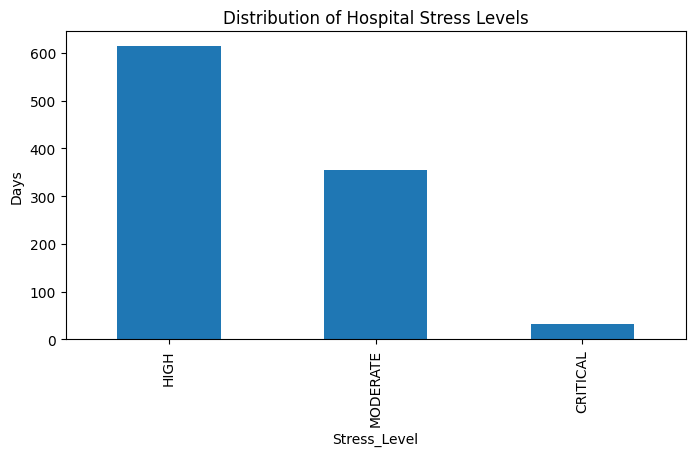

In [16]:
data['Stress_Level'].value_counts().plot(kind='bar', figsize=(8,4))
plt.title("Distribution of Hospital Stress Levels")
plt.ylabel("Days")
plt.show()

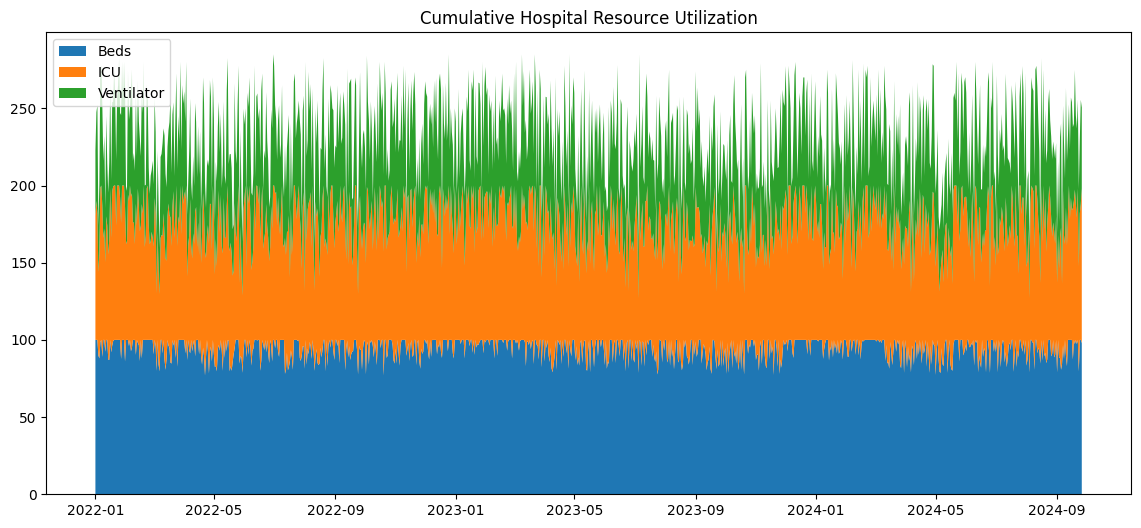

In [17]:
plt.figure(figsize=(14,6))
plt.stackplot(data['Date'],
              data['Bed_Occupancy_Rate'],
              data['ICU_Occupancy_Rate'],
              data['Ventilator_Utilization_Rate'],
              labels=['Beds','ICU','Ventilator'])
plt.legend(loc='upper left')
plt.title("Cumulative Hospital Resource Utilization")
plt.show()

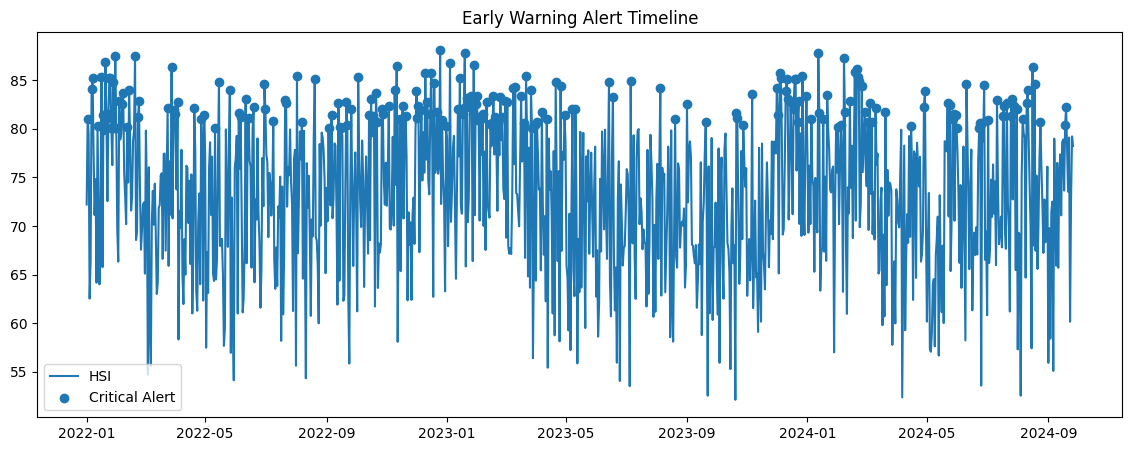

In [18]:
plt.figure(figsize=(14,5))
plt.plot(data['Date'], data['HSI'], label="HSI")

critical = data[data['HSI'] > 80]
plt.scatter(critical['Date'], critical['HSI'], label="Critical Alert")

plt.legend()
plt.title("Early Warning Alert Timeline")
plt.show()

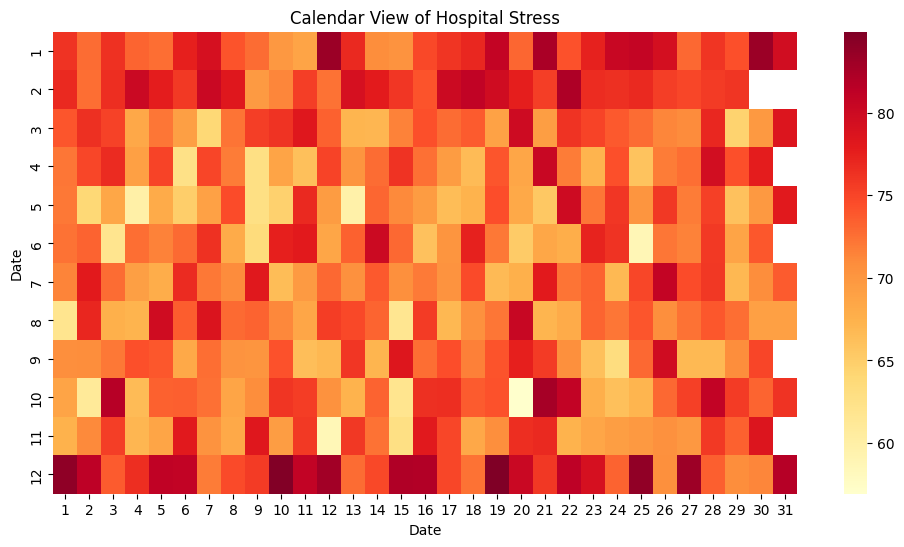

In [19]:
pivot = data.pivot_table(index=data['Date'].dt.month,
                         columns=data['Date'].dt.day,
                         values='HSI')

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlOrRd')
plt.title("Calendar View of Hospital Stress")
plt.show()